In [ ]:
#| default_exp attention_gated_unet

In [1]:
#| export
import torch 
from torch.utils.data import Dataset, DataLoader
import tifffile as tiff
import numpy as np
import cv2
from fastcore.all import *
import albumentations as A
from torch import nn
from sklearn.model_selection import train_test_split

In [46]:
import matplotlib.pyplot as plt

In [3]:
#| export
from tqdm import tqdm
from torch.amp import autocast

In [4]:
#| export
from yolo_v8_segmentation.viz_utils import *

In [31]:
im_path = Path(r'/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images')
lbl_path = Path(r'/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/labels')

In [32]:
im_path.ls(), lbl_path.ls()

((#2279) [Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/2104.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/2026.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/0039.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/1552.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/0017.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/0268.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/2137.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vessel-segmentation/train/kidney_1_dense/images/0333.tif'),Path('/home/hasan/Schreibtisch/projects/data/Senet/blood-vesse

In [40]:
#| export
def get_image_mask_name(im_path, lbl_path, idx):
    image_name = im_path.ls()[idx]
    name_ = Path(image_name).name
    mask_name = Path(lbl_path, name_)
    return image_name, mask_name


835


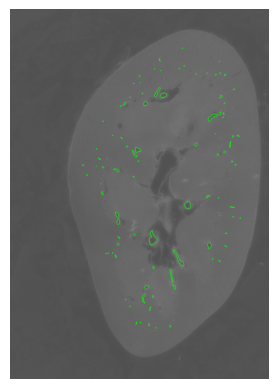

In [67]:
idx = np.random.choice(len(im_path.ls()))
print(idx)
im_name, msk_name = get_image_mask_name(im_path, lbl_path, idx)
overlay_mask_border_on_image(im_name, msk_name)

In [68]:
#| export
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [69]:
#| export
class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [72]:
#| export   
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)
    def forward(self, gate, skip_connection):
            """
            :param gate: gating signal from previous layer
            :param skip_connection: activation from corresponding encoder layer
            :return: output activations
            """
            g1 = self.W_gate(gate)
            x1 = self.W_x(skip_connection)
            psi = self.relu(g1 + x1)
            psi = self.psi(psi)
            out = skip_connection * psi
            return out

In [74]:
#| export
class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, gate, skip_connection):
            """
            :param gate: gating signal from previous layer
            :param skip_connection: activation from corresponding encoder layer
            :return: output activations
            """
            g1 = self.W_gate(gate)
            x1 = self.W_x(skip_connection)
            psi = self.relu(g1 + x1)
            psi = self.psi(psi)
            out = skip_connection * psi
            return out

In [75]:
#| export
def dice_coeff(prediction, target, threshold=0.5):

    mask = np.zeros_like(prediction)
    mask[prediction >= threshold] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

In [76]:
#| export
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss